# **데이터 불러오기**

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/데자뷰")
%ls

covid_test_cluster.html  funda_train.csv  test.csv   transfill.csv
festFood.csv             submission.csv   train.csv


In [ ]:
# 필요한 패키지 로드
import numpy as np
import pandas as pd

import lightgbm as lgbm

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# funda_train.csv 데이터 불러오기

data = pd.read_csv('funda_train.csv')

data['date'] = data['transacted_date'] + ' ' + data['transacted_time']
data['date'] = pd.to_datetime(data['date'])

data.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,date
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016-06-02 11:06:00


In [ ]:
# 결측치 확인
data.isna().sum()

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
date                      0
dtype: int64

# **데이터 추출**

* festFood: 피자, 햄버거, 샌드위치 및 유사 음식점업
* bakery: 제과점업
* beverage: 비알코올 음료점업
* chicken: 치킨 전문점
* bvRetail: 음료 소매업
* kimbab: 김밥 및 기타 간이 음식점업
* china: 중식 음식점업
* korea: 한식 음식점업
* ffTakeout: 간이음식 포장 판매 전문점
* west: 서양식 음식점업
* etcDrink: 기타 주점업
* etcForeign: 기타 외국식 음식점업
* japan: 일식 음식점업

In [ ]:
# 피자, 햄버거, 샌드위치 및 유사 음식점업 데이터 추출
festFood = data[data.type_of_business == "피자, 햄버거, 샌드위치 및 유사 음식점업"]

# 제과점업
bakery = data[data.type_of_business == "제과점업"]

# 비알코올 음료점업
beverage = data[data.type_of_business == "비알코올 음료점업"]

# 치킨 전문점
chicken = data[data.type_of_business == "치킨 전문점"]

# 음료 소매업
bvRetail = data[data.type_of_business == "음료 소매업"]

# 김밥 및 기타 간이 음식점업
kimbab = data[data.type_of_business == "김밥 및 기타 간이 음식점업"]

# 중식 음식점업
china = data[data.type_of_business == "중식 음식점업"]

# 한식 음식점업
korea = data[data.type_of_business == "한식 음식점업"]

# 간이음식 포장 판매 전문점
ffTakeout = data[data.type_of_business == "간이음식 포장 판매 전문점"]

# 서양식 음식점업
west = data[data.type_of_business == "서양식 음식점업"]

# 기타 주점업
etcDrink = data[data.type_of_business == "기타 주점업"]

# 기타 외국식 음식점업
etcForeign = data[data.type_of_business == "기타 외국식 음식점업"]

# 일식 음식점업
japan = data[data.type_of_business == "일식 음식점업"]

# **음수 제거**

음수(환불)를 제거하려고 코드를 짜봤지만 잘 안 되었기 때문에 수상자 코드 사용

https://dacon.io/competitions/official/140472/codeshare/953?page=1&dtype=view&ptype=pub

In [ ]:
##환불 노이즈를 제거 하는 함수

from tqdm import tqdm

def refund_remove(df):
    refund=df[df['amount']<0]
    non_refund=df[df['amount']>0]
    remove_data=pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data=non_refund[non_refund['store_id']==i] ##non_refund 스토어 데이터를 스토어별로 나눔
        divided_data2=refund[refund['store_id']==i] ##refund 스토어 데이터를 나눔 스토어별로 나눔
        
        for neg in divided_data2.to_records()[:]: ##환불데이터를 차례대로 검사
            refund_store=neg['store_id']
            refund_id=neg['card_id'] ## 환불 카드 아이디
            refund_datetime=neg['date'] ## 환불 시간
            refund_amount=abs(neg['amount']) ## 환불액 절대값을 씌움
                
            ##환불시간 이전의 데이터중 카드이이디와 환불액이 같은 후보 리스트를 뽑는다.
            refund_pay_list=divided_data[divided_data['date']<=refund_datetime]
            refund_pay_list=refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list=refund_pay_list[refund_pay_list['amount']==refund_amount]
                
                
            #후보리스트가 있으면,카드아이디, 환불액이 같으면서 가장 최근시간을 제거
            if(len(refund_pay_list)!=0):
                refund_datetime=max(refund_pay_list['date']) ##가장 최근 시간을 구한다
                remove=divided_data[divided_data['date']==refund_datetime] ##가장 최근시간
                remove=remove[remove['card_id']==refund_id] ##환불 카드 아이디
                remove=remove[remove['amount']==refund_amount] ##환불액
                divided_data=divided_data.drop(index=remove.index) #인덱스를 통해 제거
                    
        ##제거한데이터를 데이터프레임에 추가한다.
        remove_data=pd.concat([remove_data,divided_data],axis=0)
    
    return remove_data

In [ ]:
# festFood 음수 제거
newff = refund_remove(festFood)

# bakery 음수 제거
newbk = refund_remove(bakery)

# beverage 음수 제거
newbv = refund_remove(beverage)

# chicken 음수 제거
newck = refund_remove(chicken)

# bvRetail 음수 제거
newbvRe = refund_remove(bvRetail)

# kimbab 음수 제거
newkimbab = refund_remove(kimbab)

# china 음수 제거
newchina = refund_remove(china)

# korea 음수 제거
newkorea = refund_remove(korea)

# ffTakeout 음수 제거
newffTake = refund_remove(ffTakeout)

# west 음수 제거
newwest = refund_remove(west)

# etcDrink 음수 제거
newetcD= refund_remove(etcDrink)

# etcForeign 음수 제거
newetcF = refund_remove(etcForeign)

# japan 음수 제거
newjapan = refund_remove(japan)

100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


# **시간대별 금액 변화, 건수 변화**

In [ ]:
# hour 변수 생성
newff['hour'] = newff['transacted_time'].str[0:2]
newbk['hour'] = newbk['transacted_time'].str[0:2]
newbv['hour'] = newbv['transacted_time'].str[0:2]
newck['hour'] = newck['transacted_time'].str[0:2]
newbvRe['hour'] = newbvRe['transacted_time'].str[0:2]
newkimbab['hour'] = newkimbab['transacted_time'].str[0:2]
newchina['hour'] = newchina['transacted_time'].str[0:2]
newkorea['hour'] = newkorea['transacted_time'].str[0:2]
newffTake['hour'] = newffTake['transacted_time'].str[0:2]
newwest['hour'] = newwest['transacted_time'].str[0:2]
newetcD['hour'] = newetcD['transacted_time'].str[0:2]
newetcF['hour'] = newetcF['transacted_time'].str[0:2]
newjapan['hour'] = newjapan['transacted_time'].str[0:2]

In [ ]:
# 필요한 변수(hour, amount)만 선택
ffAmount = newff[['hour', 'amount']]
bkAmount = newbk[['hour', 'amount']]
bvAmount = newbv[['hour', 'amount']]
ckAmount = newck[['hour', 'amount']]
bvRetailAmount = newbvRe[['hour', 'amount']]
kimbabAmount = newkimbab[['hour', 'amount']]
chinaAmount = newchina[['hour', 'amount']]
koreaAmount = newkorea[['hour', 'amount']]
ffTakeAmount = newffTake[['hour', 'amount']]
westAmount = newwest[['hour', 'amount']]
etcDAmount = newetcD[['hour', 'amount']]
etcFAmount = newetcF[['hour', 'amount']]
japanAmount = newjapan[['hour', 'amount']]

## **시간대별 count**

In [ ]:
ff_gc = ffAmount.groupby('hour').count()
ff_gc.rename(columns = {'amount' : 'festFood'}, inplace = True)
ff_gc = ff_gc.transpose()

bk_gc = bkAmount.groupby('hour').count()
bk_gc.rename(columns = {'amount' : 'bakery'}, inplace = True)
bk_gc = bk_gc.transpose()

bv_gc = bvAmount.groupby('hour').count()
bv_gc.rename(columns = {'amount' : 'beverage'}, inplace = True)
bv_gc = bv_gc.transpose()

ck_gc = ckAmount.groupby('hour').count()
ck_gc.rename(columns = {'amount' : 'chicken'}, inplace = True)
ck_gc = ck_gc.transpose()

bvRetail_gc = bvRetailAmount.groupby('hour').count()
bvRetail_gc.rename(columns = {'amount' : 'bvRetail'}, inplace = True)
bvRetail_gc = bvRetail_gc.transpose()

kimbab_gc = kimbabAmount.groupby('hour').count()
kimbab_gc.rename(columns = {'amount' : 'kimbab'}, inplace = True)
kimbab_gc = kimbab_gc.transpose()

china_gc = chinaAmount.groupby('hour').count()
china_gc.rename(columns = {'amount' : 'china'}, inplace = True)
china_gc = china_gc.transpose()

korea_gc = koreaAmount.groupby('hour').count()
korea_gc.rename(columns = {'amount' : 'korea'}, inplace = True)
korea_gc = korea_gc.transpose()

ffTake_gc = ffTakeAmount.groupby('hour').count()
ffTake_gc.rename(columns = {'amount' : 'ffTakeout'}, inplace = True)
ffTake_gc = ffTake_gc.transpose()

west_gc = westAmount.groupby('hour').count()
west_gc.rename(columns = {'amount' : 'west'}, inplace = True)
west_gc = west_gc.transpose()

etcD_gc = etcDAmount.groupby('hour').count()
etcD_gc.rename(columns = {'amount' : 'etcDrink'}, inplace = True)
etcD_gc = etcD_gc.transpose()

etcF_gc = etcFAmount.groupby('hour').count()
etcF_gc.rename(columns = {'amount' : 'etcForeign'}, inplace = True)
etcF_gc = etcF_gc.transpose()

japan_gc = japanAmount.groupby('hour').count()
japan_gc.rename(columns = {'amount' : 'japan'}, inplace = True)
japan_gc = japan_gc.transpose()

groupedCount = pd.concat([ff_gc, bk_gc, bv_gc, ck_gc, bvRetail_gc, kimbab_gc, china_gc, korea_gc, ffTake_gc, west_gc, etcD_gc, etcF_gc, japan_gc])
groupedCount = groupedCount.transpose()
groupedCount = groupedCount.fillna(0)
groupedCount

,festFood,bakery,beverage,chicken,bvRetail,kimbab,china,korea,ffTakeout,west,etcDrink,etcForeign,japan
00,101.0,0.0,251.0,3777.0,597.0,314.0,0.0,24683.0,6573.0,4693.0,14838.0,1010.0,4188.0
01,23.0,0.0,89.0,1787.0,549.0,46.0,0.0,15065.0,4183.0,3352.0,10478.0,750.0,2285.0
02,8.0,0.0,11.0,707.0,281.0,12.0,0.0,8660.0,2024.0,2123.0,5613.0,510.0,1010.0
03,3.0,0.0,1.0,190.0,66.0,18.0,0.0,4582.0,818.0,1382.0,2280.0,335.0,308.0
05,2.0,0.0,0.0,32.0,0.0,18.0,0.0,892.0,100.0,113.0,221.0,85.0,8.0
07,3.0,2.0,4.0,32.0,0.0,38.0,0.0,1808.0,11.0,5.0,9.0,8.0,1.0
08,10.0,4.0,277.0,26.0,9.0,38.0,1.0,1467.0,12.0,5.0,2.0,5.0,0.0
09,417.0,13.0,1010.0,11.0,20.0,62.0,7.0,1517.0,86.0,11.0,3.0,0.0,10.0
10,1387.0,98.0,2259.0,12.0,19.0,107.0,77.0,2943.0,563.0,46.0,0.0,1.0,48.0
11,1289.0,436.0,2921.0,100.0,68.0,954.0,1301.0,16311.0,1127.0,703.0,34.0,4.0,394.0


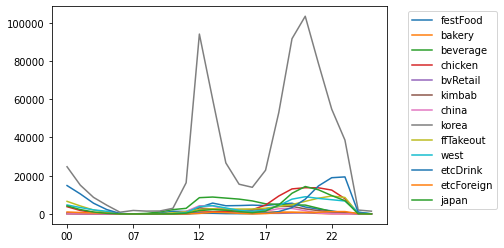

In [ ]:
# 시간대별 count plot

groupedCount.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## **시간대별 매출액 합계**

In [ ]:
ff_ga = ffAmount.groupby('hour').sum()
ff_ga.rename(columns = {'amount' : 'festFood'}, inplace = True)
ff_ga = ff_ga.transpose()

bk_ga = bkAmount.groupby('hour').sum()
bk_ga.rename(columns = {'amount' : 'bakery'}, inplace = True)
bk_ga = bk_ga.transpose()

bv_ga = bvAmount.groupby('hour').sum()
bv_ga.rename(columns = {'amount' : 'beverage'}, inplace = True)
bv_ga = bv_ga.transpose()

ck_ga = ckAmount.groupby('hour').sum()
ck_ga.rename(columns = {'amount' : 'chicken'}, inplace = True)
ck_ga = ck_ga.transpose()

bvRetail_ga = bvRetailAmount.groupby('hour').sum()
bvRetail_ga.rename(columns = {'amount' : 'bvRetail'}, inplace = True)
bvRetail_ga = bvRetail_ga.transpose()

kimbab_ga = kimbabAmount.groupby('hour').sum()
kimbab_ga.rename(columns = {'amount' : 'kimbab'}, inplace = True)
kimbab_ga = kimbab_ga.transpose()

china_ga = chinaAmount.groupby('hour').sum()
china_ga.rename(columns = {'amount' : 'china'}, inplace = True)
china_ga = china_ga.transpose()

korea_ga = koreaAmount.groupby('hour').sum()
korea_ga.rename(columns = {'amount' : 'korea'}, inplace = True)
korea_ga = korea_ga.transpose()

ffTake_ga = ffTakeAmount.groupby('hour').sum()
ffTake_ga.rename(columns = {'amount' : 'ffTakeout'}, inplace = True)
ffTake_ga = ffTake_ga.transpose()

west_ga = westAmount.groupby('hour').sum()
west_ga.rename(columns = {'amount' : 'west'}, inplace = True)
west_ga = west_ga.transpose()

etcD_ga = etcDAmount.groupby('hour').sum()
etcD_ga.rename(columns = {'amount' : 'etcDrink'}, inplace = True)
etcD_ga = etcD_ga.transpose()

etcF_ga = etcFAmount.groupby('hour').sum()
etcF_ga.rename(columns = {'amount' : 'etcForeign'}, inplace = True)
etcF_ga = etcF_ga.transpose()

japan_ga = japanAmount.groupby('hour').sum()
japan_ga.rename(columns = {'amount' : 'japan'}, inplace = True)
japan_ga = japan_ga.transpose()

groupedSum = pd.concat([ff_ga, bk_ga, bv_ga, ck_ga, bvRetail_ga, kimbab_ga, china_ga, korea_ga, ffTake_ga, west_ga, etcD_ga, etcF_ga, japan_ga])
groupedSum = groupedSum.transpose()
groupedSum = groupedSum.fillna(0)
groupedSum

,festFood,bakery,beverage,chicken,bvRetail,kimbab,china,korea,ffTakeout,west,etcDrink,etcForeign,japan
00,4.488857e+05,0.000000,1.233857e+06,1.667346e+07,2.080401e+07,8.157143e+05,0.000000e+00,1.552171e+08,4.045491e+07,4.499191e+07,1.095989e+08,6.926643e+06,3.796660e+07
01,7.235714e+04,0.000000,5.713571e+05,7.907171e+06,1.933316e+07,1.222143e+05,0.000000e+00,8.990449e+07,2.583576e+07,3.909557e+07,8.543072e+07,5.591300e+06,1.775416e+07
02,8.300000e+04,0.000000,5.181429e+04,3.163686e+06,1.036586e+07,3.775714e+04,0.000000e+00,4.828029e+07,1.179366e+07,3.131094e+07,5.361477e+07,4.302671e+06,7.422900e+06
03,1.611429e+04,0.000000,1.100000e+04,8.727000e+05,2.128429e+06,6.082857e+04,0.000000e+00,2.425351e+07,4.455514e+06,2.386431e+07,2.083989e+07,2.613500e+06,2.211800e+06
05,1.514286e+04,0.000000,0.000000e+00,1.892857e+05,0.000000e+00,5.782857e+04,0.000000e+00,5.071900e+06,6.042857e+05,2.425857e+06,1.788557e+06,9.831429e+05,4.114286e+04
07,4.571429e+03,1357.142857,1.848571e+05,1.396429e+05,0.000000e+00,1.394714e+05,0.000000e+00,8.148359e+06,1.380857e+06,6.000000e+04,1.478571e+05,1.294286e+05,8.657143e+03
08,1.181429e+04,2314.285714,1.602157e+06,1.279429e+05,5.800000e+03,1.234857e+05,2.714286e+03,1.198816e+07,4.981857e+05,8.385714e+04,2.228571e+04,1.168571e+05,0.000000e+00
09,5.457786e+05,11871.428571,3.230371e+06,5.131429e+04,1.761429e+04,1.870143e+05,2.464286e+04,1.298973e+07,1.535543e+06,5.810000e+04,6.257143e+04,0.000000e+00,9.814286e+05
10,2.462090e+06,100935.714286,6.696557e+06,8.872857e+04,1.528571e+04,5.985714e+05,2.329286e+05,2.167371e+07,2.747157e+06,1.893286e+05,0.000000e+00,1.414286e+03,3.537786e+06
11,3.323871e+06,368250.000000,6.459807e+06,4.366429e+05,6.291429e+04,2.607245e+06,3.473343e+06,7.200146e+07,1.935699e+07,2.876914e+06,3.766857e+05,2.142857e+04,5.143471e+06


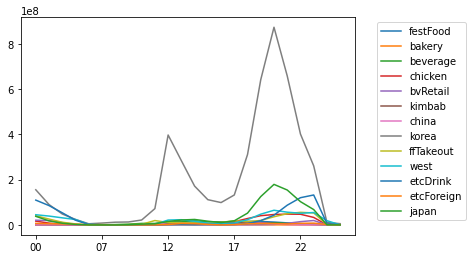

In [ ]:
# 시간대별 매출액 합계 plot
groupedSum.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## **시간대별 매출액 평균**

In [ ]:
ff_mean = ffAmount.groupby('hour').mean()
ff_mean.rename(columns = {'amount' : 'festFood'}, inplace = True)
ff_mean = ff_mean.transpose()

bk_mean = bkAmount.groupby('hour').mean()
bk_mean.rename(columns = {'amount' : 'bakery'}, inplace = True)
bk_mean = bk_mean.transpose()

bv_mean = bvAmount.groupby('hour').mean()
bv_mean.rename(columns = {'amount' : 'beverage'}, inplace = True)
bv_mean = bv_mean.transpose()

ck_mean = ckAmount.groupby('hour').mean()
ck_mean.rename(columns = {'amount' : 'chicken'}, inplace = True)
ck_mean = ck_mean.transpose()

bvRetail_mean = bvRetailAmount.groupby('hour').mean()
bvRetail_mean.rename(columns = {'amount' : 'bvRetail'}, inplace = True)
bvRetail_mean = bvRetail_mean.transpose()

kimbab_mean = kimbabAmount.groupby('hour').mean()
kimbab_mean.rename(columns = {'amount' : 'kimbab'}, inplace = True)
kimbab_mean = kimbab_mean.transpose()

china_mean = chinaAmount.groupby('hour').mean()
china_mean.rename(columns = {'amount' : 'china'}, inplace = True)
china_mean = china_mean.transpose()

korea_mean = koreaAmount.groupby('hour').mean()
korea_mean.rename(columns = {'amount' : 'korea'}, inplace = True)
korea_mean = korea_mean.transpose()

ffTake_mean = ffTakeAmount.groupby('hour').mean()
ffTake_mean.rename(columns = {'amount' : 'ffTakeout'}, inplace = True)
ffTake_mean = ffTake_mean.transpose()

west_mean = westAmount.groupby('hour').mean()
west_mean.rename(columns = {'amount' : 'west'}, inplace = True)
west_mean = west_mean.transpose()

etcD_mean = etcDAmount.groupby('hour').mean()
etcD_mean.rename(columns = {'amount' : 'etcDrink'}, inplace = True)
etcD_mean = etcD_mean.transpose()

etcF_mean = etcFAmount.groupby('hour').mean()
etcF_mean.rename(columns = {'amount' : 'etcForeign'}, inplace = True)
etcF_mean = etcF_mean.transpose()

japan_mean = japanAmount.groupby('hour').mean()
japan_mean.rename(columns = {'amount' : 'japan'}, inplace = True)
japan_mean = japan_mean.transpose()

groupedMean = pd.concat([ff_mean, bk_mean, bv_mean, ck_mean, bvRetail_mean, kimbab_mean, china_mean, korea_mean, ffTake_mean, west_mean, etcD_mean, etcF_mean, japan_mean])
groupedMean = groupedMean.transpose()
groupedMean = groupedMean.fillna(0)
groupedMean

,festFood,bakery,beverage,chicken,bvRetail,kimbab,china,korea,ffTakeout,west,etcDrink,etcForeign,japan
00,4444.413013,0.000000,4915.765509,4414.472938,34847.595118,2597.816197,0.000000,6288.422992,6154.710830,9587.024748,7386.363276,6858.062235,9065.568290
01,3145.962733,0.000000,6419.743178,4424.830122,35215.222482,2656.832298,0.000000,5967.772510,6176.370343,11663.357271,8153.342459,7455.066667,7769.872960
02,10375.000000,0.000000,4710.389610,4474.802991,36889.171327,3146.428571,0.000000,5575.091059,5826.905703,14748.442231,9551.892062,8436.610644,7349.405941
03,5371.428571,0.000000,11000.000000,4593.157895,32248.917749,3379.365079,0.000000,5293.214130,5446.838980,17267.955344,9140.303885,7801.492537,7181.168831
05,7571.428571,0.000000,0.000000,5915.178571,0.000000,3212.698413,0.000000,5685.986547,6042.857143,21467.762326,8093.018746,11566.386555,5142.857143
07,1523.809524,678.571429,46214.285714,4363.839286,0.000000,3670.300752,0.000000,4506.835651,125532.467532,12000.000000,16428.571429,16178.571429,8657.142857
08,1181.428571,578.571429,5783.960805,4920.879121,644.444444,3249.624060,2714.285714,8171.891129,41515.476190,16771.428571,11142.857143,23371.428571,0.000000
09,1308.821514,913.186813,3198.387553,4664.935065,880.714286,3016.359447,3520.408163,8562.777098,17855.149502,5281.818182,20857.142857,0.000000,98142.857143
10,1775.118962,1029.956268,2964.390059,7394.047619,804.511278,5594.125501,3025.046382,7364.495801,4879.497589,4115.838509,0.000000,1414.285714,73703.869048
11,2578.643467,844.610092,2211.505355,4366.428571,925.210084,2732.961066,2669.748545,4414.288727,17175.674990,4092.338955,11078.991597,5357.142857,13054.496012


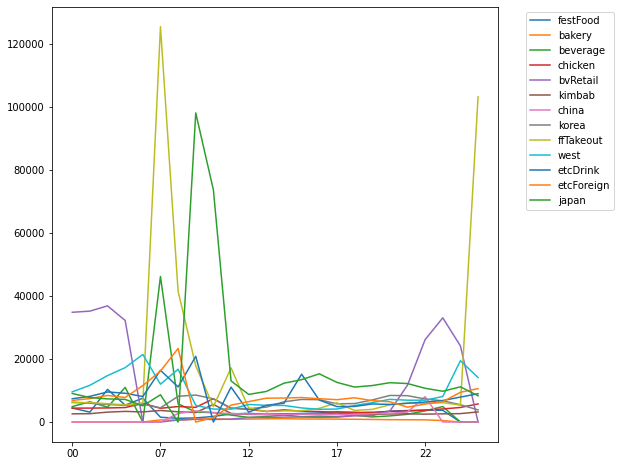

In [ ]:
# 시간대별 매출액 평균 plot
plt.rcParams["figure.figsize"] = (8, 8)    # 좀 크게 그려봄
groupedMean.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### **4개로 나눠서 다시 그리기 - 평균**

In [ ]:
# 피자, 햄버거, 샌드위치 및 유사 음식점업 / 치킨 전문점 / 제과점업
gr1 = pd.concat([ff_mean, ck_mean, bk_mean])
gr1 = gr1.transpose()
gr1 = gr1.fillna(0)

# 비알콜 음료점업 / 음료 소매업 / 기타 주점업
gr2 = pd.concat([bv_mean, bvRetail_mean, etcD_mean])
gr2 = gr2.transpose()
gr2 = gr2.fillna(0)

# 중식 음식점업 / 한식 음식점업 / 서양식 음식점업 / 일식 음식점업 / 기타 외국식 음식점업
gr3 = pd.concat([china_mean, korea_mean, west_mean, japan_mean, etcF_mean])
gr3 = gr3.transpose()
gr3 = gr3.fillna(0)

# 김밥 및 기타 간이 음식점업 / 간이음식 포장 판매 전문점
gr4 = pd.concat([kimbab_mean, ffTake_mean])
gr4 = gr4.transpose()
gr4 = gr4.fillna(0)

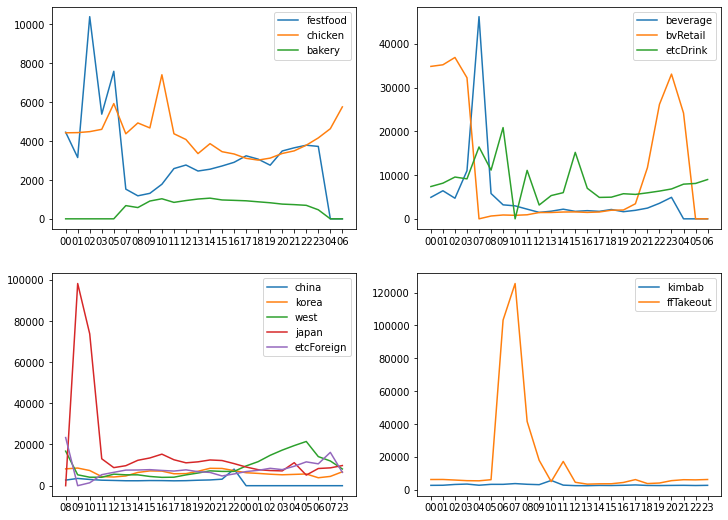

In [ ]:
# 4개 한 번에 그리기

plt.figure(figsize=(12,9))

plt.subplot(221)
plt.plot(gr1)
plt.legend(['festfood', 'chicken', 'bakery'])

plt.subplot(222)
plt.plot(gr2)
plt.legend(['beverage', 'bvRetail', 'etcDrink'])

plt.subplot(223)
plt.plot(gr3)
plt.legend(['china', 'korea', 'west', 'japan', 'etcForeign'])

plt.subplot(224)
plt.plot(gr4)
plt.legend(['kimbab', 'ffTakeout'])

## **A, B, C, D, Etc 별로 따로 그려보기**

In [ ]:
g1 = pd.concat([china_mean, korea_mean, west_mean, kimbab_mean])
g1 = g1.transpose()
g1 = g1.fillna(0)

g2 = pd.concat([bvRetail_mean, etcD_mean, japan_mean])
g2 = g2.transpose()
g2 = g2.fillna(0)

g3 = pd.concat([ff_mean, bk_mean])
g3 = g3.transpose()
g3 = g3.fillna(0)

g4 = pd.concat([bv_mean, ffTake_mean])
g4 = g4.transpose()
g4 = g4.fillna(0)

g5 = pd.concat([ck_mean, etcF_mean])
g5 = g5.transpose()
g5 = g5.fillna(0)

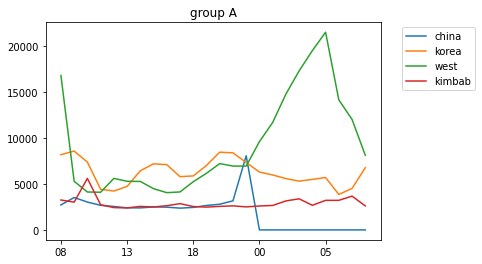

In [ ]:
# A 시간대별 매출액 평균 plot
g1.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('group A')
plt.show()

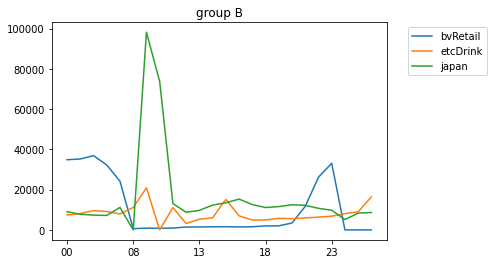

In [ ]:
# B 시간대별 매출액 평균 plot
g2.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('group B')
plt.show()

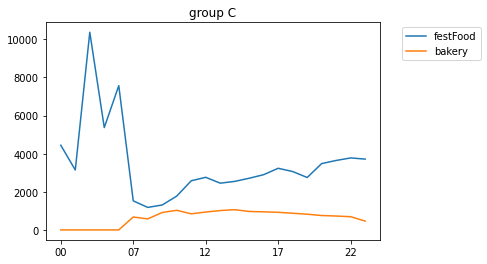

In [ ]:
# C 시간대별 매출액 평균 plot
g3.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('group C')
plt.show()

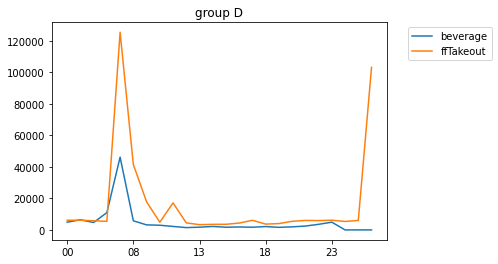

In [ ]:
# D 시간대별 매출액 평균 plot
g4.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('group D')
plt.show()

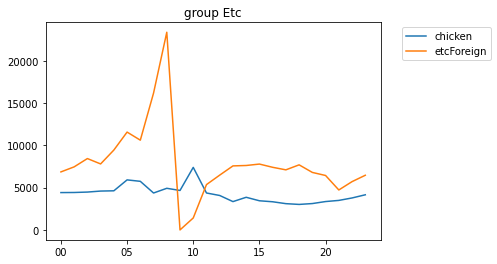

In [ ]:
# etc 시간대별 매출액 평균 plot
g5.plot()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('group Etc')
plt.show()

# **매출금액 평균, 분산, min, max**

In [ ]:
# festFood describe
ffAmount.describe()

,amount
count,48812.000000
mean,2889.363652
std,5064.962078
min,2.857143
25%,971.428571
50%,2414.285714
75%,3585.714286
max,552857.142857


In [ ]:
# bakery describe
bkAmount.describe()

,amount
count,8889.000000
mean,919.288687
std,1096.658730
min,114.285714
25%,457.142857
50%,742.857143
75%,1071.428571
max,50000.000000


In [ ]:
# beverage describe
bvAmount.describe()

,amount
count,71392.000000
mean,2004.566348
std,13637.108849
min,7.714286
25%,628.571429
50%,1014.285714
75%,1714.285714
max,714285.714286


In [ ]:
# chicken describe
ckAmount.describe()

,amount
count,88082.000000
mean,3519.567273
std,3240.811996
min,0.285714
25%,2285.714286
50%,2857.142857
75%,3785.714286
max,214285.714286


In [ ]:
# bvRetail describe
bvRetailAmount.describe()

,amount
count,7608.000000
mean,13380.565551
std,23139.373950
min,14.142857
25%,1114.285714
50%,2042.857143
75%,14285.714286
max,204285.714286


In [ ]:
# kimbab describe
kimbabAmount.describe()

,amount
count,29998.000000
mean,2566.527216
std,5441.572532
min,2.000000
25%,1714.285714
50%,2142.857143
75%,2857.142857
max,414285.714286


In [ ]:
# china describe
chinaAmount.describe()

,amount
count,24005.000000
mean,2531.888595
std,2449.929861
min,14.285714
25%,1285.714286
50%,2000.000000
75%,3000.000000
max,91571.428571


In [ ]:
# korea describe
koreaAmount.describe()

,amount
count,7.349010e+05
mean,6.542155e+03
std,1.215616e+04
min,8.571429e-01
25%,2.571429e+03
50%,4.357143e+03
75%,7.285714e+03
max,1.357429e+06


In [ ]:
# ffTakeout describe
ffTakeAmount.describe()

,amount
count,7.311400e+04
mean,5.566053e+03
std,2.186388e+04
min,1.428571e+00
25%,1.714286e+03
50%,3.285714e+03
75%,5.285714e+03
max,1.527429e+06


In [ ]:
# west describe
westAmount.describe()

,amount
count,73469.000000
mean,7421.838542
std,9192.677566
min,2.285714
25%,3214.285714
50%,4928.571429
75%,8000.000000
max,614285.714286


In [ ]:
# etcDrink describe
etcDAmount.describe()

,amount
count,101038.000000
mean,6881.140483
std,11431.129703
min,14.285714
25%,3285.714286
50%,4714.285714
75%,7000.000000
max,785714.285714


In [ ]:
# etcForeign describe
etcFAmount.describe()

,amount
count,10862.000000
mean,6899.983428
std,5624.393196
min,142.857143
25%,3285.714286
50%,6285.714286
75%,8428.571429
max,125000.000000


In [ ]:
# japan describe
japanAmount.describe()

,amount
count,76574.000000
mean,11268.775073
std,15846.039150
min,0.142857
25%,5000.000000
50%,8000.000000
75%,13285.714286
max,928571.428571
